# GPU使用の検討

In [1]:
%load_ext autoreload

%autoreload 2
import time

import pandas
import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions


from chainer.datasets import tuple_dataset
from chainer.dataset import convert, concat_examples

import numpy
import os
import glob
import sys
from pathlib import Path

import easy_chainer

In [3]:
import cupy

In [4]:
# if using GPU
def parse_device(args):
    gpu = None
    if args.gpu is not None:
        gpu = args.gpu
    elif re.match(r'(-|\+|)[0-9]+$', args.device):
        gpu = int(args.device)

    if gpu is not None:
        if gpu < 0:
            return chainer.get_device(numpy)
        else:
            import cupy
            return chainer.get_device((cupy, gpu))

    return chainer.get_device(args.device)

In [5]:
import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions


from chainer.datasets import tuple_dataset
from chainer.dataset import convert, concat_examples
from pylab import *

import pandas
import numpy

%matplotlib inline


# Dropout 検討
## blood_glucose_level.ipynb をもとに拡張

In [105]:
import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions


from chainer.datasets import tuple_dataset
from chainer.dataset import convert, concat_examples
from pylab import *

import pandas
import numpy
import cupy

%matplotlib inline

import easy_chainer

In [106]:
# 1,000datas
data, teach = easy_chainer.load_Data("/home/fiber_classifier/Desktop/wrist_height_length_random_1000.xls")
data = data.astype(numpy.float32)
teach = teach
print(teach)

[194.  97. 150. 222. 109. 165. 135. 205. 122. 172. 167. 142. 111. 160.
  93. 119. 160. 103. 133. 149. 100. 129. 219.  94.  93.  94. 232.  94.
 108. 105. 105. 188. 107. 171. 206. 167. 208. 163. 169.  97. 166. 192.
 158. 175. 171. 103. 140. 146.  94. 109. 121. 177. 159. 108. 210.  94.
 203. 104. 140. 112.]


In [47]:
class MultiLayerPerceptron(chainer.Chain):
    '''
    モデルの定義（多層パーセプトロン）
    '''
    
    def __init__(self, input_dim, n_units, output_dim, train=True, drop_out_ratio=0.3):
        '''
        コンストラクタ
        '''
        # 多層パーセプトロンの各層の定義
        super(MultiLayerPerceptron, self).__init__(
            l1=F.Linear(input_dim, n_units),
            l2=F.Linear(n_units, n_units),
            l3=F.Linear(n_units, output_dim)
        )
        # 学習の場合：True
        self.__train = train
        # drop outの実施有無
        self.__drop_out = True
        # drop outの比率
        self.drop_out_ratio = drop_out_ratio
    
    def __call__(self, x):
        '''
        順伝搬（foward）計算
        '''
        # 入力層から順に計算（多層パーセプトロンの構造）
        drop_out = self.__train and self.__drop_out 
        h1 = F.dropout(F.relu(self.l1(x)), train=drop_out, ratio=self.drop_out_ratio)
        h2 = F.dropout(F.relu(self.l2(h1)), train=drop_out, ratio=self.drop_out_ratio)
        y  = self.l3(h2)
        
        return y
    
    # 学習の場合；True
    def __get_train(self):
        return self.__train
    
    def __set_train(self, train):
        self.__train = train
        
    train = property(__get_train, __set_train)
    
    # Dropoutを使用する場合：True
    def __get_drop_out(self):
        return self.__drop_out
    
    def __set_drop_out(self, drop_out):
        '''
        drop outフラグの設定
        '''
        self.__drop_out = drop_out
    
    drop_out = property(__get_drop_out, __set_drop_out)

In [115]:
# 4層NN(入力→中間，中間→出力)
class MLP_12(chainer.Chain):
    
    """
    モデルの実装
    """

    def __init__(self, n_units, n_out, train=True, drop_out_ratio=0.3):
        super(MLP_12, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out
    
        # 学習の場合：True
        self.__train = train
        # drop outの実施有無
        self.__drop_out = True
        # drop outの比率
        self.drop_out_ratio = drop_out_ratio
    

    def __call__(self, x):
        drop_out = self.__train and self.__drop_out 
        h1 = F.dropout(F.relu(self.l1(x)), ratio=self.drop_out_ratio)
        h2 = F.dropout(F.relu(self.l2(h1)), ratio=self.drop_out_ratio)
        return self.l3(h2)
    
    
    # 学習の場合；True
    def __get_train(self):
        return self.__train
    
    def __set_train(self, train):
        self.__train = train
        
    train = property(__get_train, __set_train)
    
    # Dropoutを使用する場合：True
    def __get_drop_out(self):
        return self.__drop_out
    
    def __set_drop_out(self, drop_out):
        '''
        drop outフラグの設定
        '''
        self.__drop_out = drop_out
    
    drop_out = property(__get_drop_out, __set_drop_out)

def parse_device(args):
    gpu = None
    if args.gpu is not None:
        gpu = args.gpu
    elif re.match(r'(-|\+|)[0-9]+$', args.device):
        gpu = int(args.device)

    if gpu is not None:
        if gpu < 0:
            return chainer.get_device(numpy)
        else:
            import cupy
            return chainer.get_device((cupy, gpu))

    return chainer.get_device(args.device)

In [108]:
# 回帰させるときに必要（分類はint型）
teach = teach.astype(numpy.float32)

In [109]:
id_all = numpy.arange(1, len(teach) + 1, 1).astype(numpy.int32) - 1
# print(id_all)

In [110]:
# 訓練データ
numpy.random.seed(13)
id_train = numpy.random.choice(id_all, 30, replace=False) #重複なし
print(id_train)
print(id_train.shape)

[33  4 31 56  0 14 43 30 23  6 27 29 51 47 15 53 45 40 17  5  3  7 55 20
 41 50 49 12  8 54]
(30,)


In [111]:
# テストデータ
id_test = numpy.delete(id_all, id_train)
print(id_test)

[ 1  2  9 10 11 13 16 18 19 21 22 24 25 26 28 32 34 35 36 37 38 39 42 44
 46 48 52 57 58 59]


In [19]:
# train, test データをExcelに保存するスクリプト
# このスクリプトを追加する

teach_train = teach[id_train]
df_teach = pandas.DataFrame(teach_train, columns=['train'])
df_idtrain = pandas.DataFrame(id_train, columns=['id_train'])
df_train = pandas.concat([df_idtrain, df_teach], axis=1)
# print(df_train)

teach_test = teach[id_test]
df_id_test = pandas.DataFrame(teach_test, columns=['test'])
df_idtest = pandas.DataFrame(id_test, columns=['id_test'])
df_test = pandas.concat([df_idtest, df_id_test], axis=1)
# print(df_test)

df = pandas.concat([df_train, df_test], axis=1)
df.to_excel("blood_glucose_teach_20191003.xlsx")
# print(df)

In [112]:
x_train, y_train = data[:, id_train], teach[id_train]
x_test, y_test = data[:, id_test], teach[id_test]

In [113]:
train = tuple_dataset.TupleDataset(x_train.T, y_train.reshape(-1,1 ))
test = tuple_dataset.TupleDataset(x_test.T, y_test.reshape(-1, 1))

# batch size を決める　全データを使うならバッチ学習　使わないならミニバッチ学習（SGDとかが効いてくる）
train_iter = chainer.iterators.SerialIterator(train, 10)
test_iter = chainer.iterators.SerialIterator(test, 10, repeat=False, shuffle=False)

In [116]:
# model 決定　1000ノード　1出力
net = MLP_12(1000, 1, 0.3)
model = L.Classifier(net,
                     lossfun=F.mean_squared_error,
                     accfun=F.r2_score)
model.compute_accuracy = False

model.to_gpu()

In [65]:
drop_out_ratio = 0.3

In [117]:
# 最適化方法
#optimizer = chainer.optimizers.SGD()
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [118]:
# 学習回数（epoch）とかを決める
updater = training.updaters.StandardUpdater(train_iter, optimizer, device=0)
trainer = training.Trainer(updater, (2000, 'epoch'), out="Result2019_oono/%s" % time.strftime("%Y%m%d%H%M%S"))
out_directory = "./Result2019_oono/%s" % time.strftime("%Y%m%d_%H%M%S")

In [119]:
# オプションです

# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model, device=0))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot for each specified epoch
# frequency = args.epoch if args.frequency == -1 else max(1, args.frequency)
# trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# Print a progress bar to stdout
trainer.extend(extensions.ProgressBar())

# if args.resume:
#     # Resume from a snapshot
#     chainer.serializers.load_npz(args.resume, trainer)


In [120]:
# 訓練実行！
trainer.run()

# モデル保存
net.to_cpu()

chainer.serializers.save_hdf5("/home/fiber_classifier/Desktop/model.hdf" ,obj=net)

numpy.save(arr=id_test, file="/home/fiber_classifier/Desktop/test_id.npy"  )
numpy.save(arr=id_train, file="/home/fiber_classifier/Desktop/train_id.npy" )


epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           20103.9     16767.3                                                        0.0179812     
2           12413.1     6131.76                                                        0.134331      
3           3845.2      2407.31                                                        0.255917      
4           5168.62     4640.8                                                         0.382256      
5           3513.65     1633.81                                                        0.50428       
6           1863.68     2472.09                                                        0.628656      
7           2814.06     3277.32                                                        0.746891      
8           3307.91     2568.3                                                         0.867373      
9           1928.62     1631.54                                                     

74          1361.58     1082.83                                                        14.4918       
75          1649.65     1098.68                                                        14.6183       
76          1339.29     1135.41                                                        14.8595       
77          1558.75     1069.31                                                        14.9824       
78          1400.6      1059.91                                                        15.1095       
79          1183.95     1151.06                                                        15.2366       
80          1276.55     1092.66                                                        15.3635       
81          1369.76     1056.05                                                        15.4906       
82          1202.07     1048.83                                                        15.6181       
83          1448.46     1087                                                      

148         559.641     888.719                                                        24.18         
149         583.682     865.53                                                         24.3095       
150         574.594     869.322                                                        24.4382       
151         452.865     921.786                                                        24.5672       
152         814.682     862.933                                                        24.6967       
153         574.2       1066.53                                                        24.8261       
154         611.63      858.255                                                        24.9571       
155         611.018     872.099                                                        25.0871       
156         852.13      869.622                                                        25.218        
157         509.58      1064.46                                                   

222         766.336     984.973                                                        34.2365       
223         757.131     894.041                                                        34.3646       
224         424.988     1319.16                                                        34.49         
225         588.047     947.344                                                        34.613        
226         965.112     873.879                                                        34.738        
227         829.437     1470.63                                                        34.8642       
228         768.383     1087.34                                                        34.9914       
229         703.297     820.366                                                        35.1162       
230         606.583     1091.34                                                        35.242        
231         663.502     880.603                                                   

296         397.784     841.898                                                        44.0271       
297         469.644     830.044                                                        44.1567       
298         382.786     809.458                                                        44.2869       
299         372.721     815.841                                                        44.4166       
300         443.153     816.43                                                         44.5487       
     total [#######...........................................] 15.00%
this epoch [..................................................]  0.00%
       900 iter, 300 epoch / 2000 epochs
    22.689 iters/sec. Estimated time to finish: 0:03:44.778951.
301         450.101     934.57                                                         44.6802       
302         625.213     910.785                                                        44.8101       
303         679.999     806.382        

367         277.947     943.59                                                         53.7966       
368         423.666     795.215                                                        53.93         
369         362.476     798.454                                                        54.0646       
370         397.411     815.49                                                         54.1986       
371         277.38      832.023                                                        54.3316       
372         380.928     790.346                                                        54.4642       
373         335.302     803.712                                                        54.5976       
374         581.88      817.002                                                        54.7298       
375         549.122     834.568                                                        54.8626       
376         455.131     803.562                                                   

441         460.985     820.603                                                        64.1645       
442         362.383     937.93                                                         64.292        
443         422.687     819.177                                                        64.4211       
444         455.511     796.771                                                        64.5498       
445         461.071     810.766                                                        64.6779       
446         489.69      807.712                                                        64.8057       
447         432.929     793.748                                                        64.9336       
448         410.709     853.97                                                         65.0606       
449         472.267     817.377                                                        65.1884       
450         403.942     813.822                                                   

515         470.368     955.764                                                        73.7228       
516         404.12      888.153                                                        73.8534       
517         485.798     784.813                                                        73.9835       
518         467.079     984.341                                                        74.113        
519         478.245     831.411                                                        74.9293       
520         427.552     780.192                                                        75.0596       
521         381.726     1002.93                                                        75.1906       
522         392.149     786.748                                                        75.3209       
523         463.637     785.435                                                        75.4508       
524         371.819     796.387                                                   

589         398.745     760.731                                                        84.1262       
590         357.787     784.77                                                         84.2596       
591         381.369     821.354                                                        84.3935       
592         419.798     801.889                                                        84.5279       
593         279.471     777.965                                                        84.6631       
594         455.992     839.455                                                        84.797        
595         464.574     851.344                                                        84.9313       
596         390.391     820.281                                                        85.0657       
597         541.792     891.094                                                        85.2003       
598         433.149     805.253                                                   

663         456.405     815.859                                                        94.9548       
664         388.157     814.261                                                        95.0905       
665         370.127     824.329                                                        95.2267       
666         473.752     811.759                                                        95.3619       
     total [################..................................] 33.33%
this epoch [#################################.................] 66.67%
      2000 iter, 666 epoch / 2000 epochs
    22.071 iters/sec. Estimated time to finish: 0:03:01.236571.
667         474.736     803.712                                                        95.5005       
668         268.626     902.839                                                        95.6376       
669         369.621     912.896                                                        95.776        
670         347.712     843.003        

734         520.815     818.55                                                         104.771       
735         324.45      768.524                                                        104.909       
736         204.122     800.879                                                        105.05        
737         343.776     792.362                                                        105.188       
738         329.334     858.116                                                        105.327       
739         326.299     882.075                                                        105.465       
740         490.011     779.195                                                        105.602       
741         718.909     995.716                                                        105.741       
742         291.797     859.704                                                        105.879       
743         472.919     776.318                                                   

808         542.798     808.375                                                        116.227       
809         329.094     855.229                                                        116.369       
810         341.344     819.709                                                        116.51        
811         324.555     909.425                                                        116.653       
812         470.337     870.739                                                        116.795       
813         519.774     922.252                                                        116.938       
814         311.72      1256.36                                                        117.079       
815         590.02      782.361                                                        117.22        
816         571.924     1173.26                                                        117.363       
817         636.348     1052.44                                                   

882         592.39      865.445                                                        126.216       
883         508.152     824.498                                                        126.351       
884         318.717     825.56                                                         126.485       
885         400.834     894.208                                                        126.618       
886         244.154     877.503                                                        126.751       
887         482.897     816.62                                                         126.885       
888         303.422     894.347                                                        127.018       
889         372.388     802.505                                                        127.151       
890         435.918     836.031                                                        127.284       
891         278.755     821.616                                                   

956         452.752     877.183                                                        136.162       
957         536.877     809.249                                                        136.3         
958         450.544     868.264                                                        136.437       
959         566.94      792.89                                                         136.576       
960         672.729     827.045                                                        136.715       
961         404.161     882.827                                                        136.853       
962         509.494     948.841                                                        136.993       
963         328.614     791.058                                                        137.129       
964         351.108     795.13                                                         137.267       
965         411.798     777                                                       

1030        290.389     802.295                                                        147.769       
1031        324.558     798.458                                                        147.908       
1032        449.332     800.845                                                        148.046       
1033        436.164     843.046                                                        148.185       
     total [#########################.........................] 51.67%
this epoch [################..................................] 33.33%
      3100 iter, 1033 epoch / 2000 epochs
    21.597 iters/sec. Estimated time to finish: 0:02:14.278447.
1034        244.28      804.707                                                        148.325       
1035        514.935     831.449                                                        148.464       
1036        299.657     811                                                            148.603       
1037        351.574     815.127       

1101        533.798     836.085                                                        157.699       
1102        460.387     911.108                                                        157.839       
1103        673.757     789.976                                                        157.981       
1104        434.84      872.439                                                        158.123       
1105        353.089     796.704                                                        158.262       
1106        510.389     1001.88                                                        158.404       
1107        442.332     832.988                                                        158.546       
1108        268.965     790.624                                                        158.687       
1109        382.929     791.075                                                        158.828       
1110        455.055     970.8                                                     

1175        553.403     1106.16                                                        168.182       
1176        506.389     895.557                                                        168.327       
1177        548.66      829.163                                                        168.471       
1178        470.384     909.516                                                        168.615       
1179        450.86      798.104                                                        168.76        
1180        340.219     915.795                                                        168.907       
1181        539.166     779.182                                                        169.052       
1182        236.031     981.983                                                        169.198       
1183        509.814     784.704                                                        169.346       
1184        378.129     908.355                                                   

1249        310.68      846.554                                                        180.608       
1250        521.589     826.969                                                        180.755       
1251        203.458     836.19                                                         180.9         
1252        538.111     797.848                                                        181.047       
1253        723.338     935.746                                                        181.19        
1254        368.935     829.781                                                        181.337       
1255        518.039     799.642                                                        181.482       
1256        231.587     814.093                                                        181.626       
1257        577.594     847.51                                                         181.77        
1258        310.154     841.467                                                   

1323        397.11      883.348                                                        191.395       
1324        217.278     822.645                                                        191.54        
1325        414.901     822.018                                                        191.686       
1326        334.987     838.219                                                        191.832       
1327        527.104     807.383                                                        191.979       
1328        467.295     806.612                                                        192.124       
1329        408.691     836.838                                                        192.271       
1330        433.307     814.208                                                        192.416       
1331        383.622     803.362                                                        192.561       
1332        310.651     822.867                                                   

1397        311.513     805.963                                                        202.346       
1398        435.465     923.622                                                        202.494       
1399        365.084     850.254                                                        202.645       
1400        243.458     937.443                                                        202.795       
     total [###################################...............] 70.00%
this epoch [..................................................]  0.00%
      4200 iter, 1400 epoch / 2000 epochs
    21.186 iters/sec. Estimated time to finish: 0:01:24.961889.
1401        587.873     794.514                                                        202.946       
1402        379.233     817.969                                                        203.095       
1403        172.399     804.346                                                        203.245       
1404        446.014     817.052       

1468        359.348     919.467                                                        213.097       
1469        567.117     836.465                                                        213.252       
1470        309.167     959.25                                                         213.403       
1471        381.772     855.537                                                        213.554       
1472        283.268     816.953                                                        213.704       
1473        465.128     832.792                                                        213.858       
1474        422.441     884.842                                                        214.01        
1475        563.018     834.996                                                        214.163       
1476        310.66      890.629                                                        214.315       
1477        519.548     834.929                                                   

1542        622.76      844.445                                                        226.488       
1543        248.989     896.838                                                        226.644       
1544        382.846     824.943                                                        226.799       
1545        331.959     887.38                                                         226.955       
1546        616.247     822.19                                                         227.109       
1547        317.767     850.028                                                        227.264       
1548        348.906     821.921                                                        227.419       
1549        539.041     825.221                                                        227.572       
1550        565.461     902.346                                                        227.727       
1551        301.058     880.869                                                   

1616        355.414     934.177                                                        237.985       
1617        461.252     857.467                                                        238.143       
1618        469.936     839.087                                                        238.297       
1619        539.881     845.489                                                        238.453       
1620        295.05      820.034                                                        238.608       
1621        454.634     829.33                                                         238.764       
1622        319.472     1002.23                                                        238.92        
1623        483.972     853.516                                                        239.076       
1624        577.91      860.724                                                        239.232       
1625        488.171     800.514                                                   

1690        305.763     819.488                                                        249.379       
1691        468.929     824.47                                                         249.533       
1692        454.838     845.747                                                        249.687       
1693        345.505     920.356                                                        249.843       
1694        623.374     826.866                                                        249.998       
1695        380.067     832.764                                                        250.153       
1696        581.283     865.997                                                        250.308       
1697        522.449     853.53                                                         250.462       
1698        554.833     863.563                                                        250.616       
1699        369.224     904.317                                                   

1764        380.943     815.634                                                        260.853       
1765        425.551     819.892                                                        261.008       
1766        419.695     826.379                                                        261.163       
     total [############################################......] 88.33%
this epoch [#################################.................] 66.67%
      5300 iter, 1766 epoch / 2000 epochs
    20.643 iters/sec. Estimated time to finish: 0:00:33.910408.
1767        358.529     833.754                                                        261.319       
1768        313.811     838.563                                                        261.472       
1769        383.539     847.184                                                        261.626       
1770        513.251     878.558                                                        261.781       
1771        569.837     834.215       

1835        368.174     835.252                                                        274.518       
1836        373.633     815.158                                                        274.675       
1837        586.72      817.614                                                        274.833       
1838        282.838     806.853                                                        274.991       
1839        339.392     869.357                                                        275.149       
1840        388.995     814.724                                                        275.306       
1841        371.964     878.112                                                        275.462       
1842        429.248     909.445                                                        275.618       
1843        563.59      1088.16                                                        275.777       
1844        681.829     875.587                                                   

1909        625.595     796.926                                                        286.207       
1910        430.52      805.759                                                        286.366       
1911        401.844     829.281                                                        286.527       
1912        359.327     818.041                                                        286.688       
1913        318.767     814.04                                                         286.849       
1914        430.262     833.316                                                        287.011       
1915        421.227     838.06                                                         287.173       
1916        427.047     874.514                                                        287.334       
1917        407.066     877.528                                                        287.496       
1918        331.231     852.981                                                   

1983        588.819     823.872                                                        298.115       
1984        250.482     858.614                                                        298.278       
1985        387.009     839.456                                                        298.438       
1986        559.641     869.053                                                        298.598       
1987        649.364     854.325                                                        298.759       
1988        394.114     905.943                                                        298.92        
1989        364.096     828.436                                                        299.082       
1990        385.708     942.207                                                        299.242       
1991        597.966     840.894                                                        299.402       
1992        394.94      920.349                                                   

In [67]:
# 検証（テストデータ）
test_iter.reset()

test_batch = test_iter.next()
test_spc, test_ref = concat_examples(test_batch)  # Test Dataset
for i in range(10):
    ref = test_ref[i]
    pred = net(test_spc[i].reshape(1, -1)).data
    print("Ref: %d, Pred: %d " % (ref, pred))


Ref: 97, Pred: 88 
Ref: 150, Pred: 165 
Ref: 172, Pred: 176 
Ref: 167, Pred: 127 
Ref: 142, Pred: 162 
Ref: 160, Pred: 167 
Ref: 160, Pred: 186 
Ref: 133, Pred: 103 
Ref: 149, Pred: 182 
Ref: 129, Pred: 135 


In [121]:
# 検証（訓練データ）
train_iter.reset()

train_batch = train_iter.next()
train_spc, train_ref = concat_examples(train_batch)  # Test Dataset
for i in range(10):
    cal_ref = train_ref[i]
    cal_pred = net(train_spc[i].reshape(1, -1)).data
    print("Ref: %d, Pred: %d " % (cal_ref, cal_pred))

Ref: 111, Pred: 91 
Ref: 166, Pred: 167 
Ref: 203, Pred: 188 
Ref: 119, Pred: 159 
Ref: 94, Pred: 84 
Ref: 93, Pred: 109 
Ref: 108, Pred: 106 
Ref: 103, Pred: 77 
Ref: 192, Pred: 192 
Ref: 175, Pred: 201 


In [73]:
# arr_ref:参照値，arr_pred:予測値（テストデータ）
arr_ref = numpy.array([97, 150, 172, 167, 142, 160, 160, 133, 149, 129])
arr_pred = numpy.array([59, 159, 172, 147, 125, 144, 180, 115, 175, 158])
print("Ref:", arr_ref.shape)
print("Pred:",arr_pred.shape)

Ref: (10,)
Pred: (10,)


In [74]:
# 相関係数の算出＆表示
cor = numpy.corrcoef(arr_ref, arr_pred)[0, 1]
print(cor)

0.80470821636189


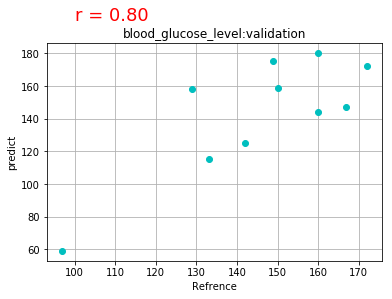

In [75]:
# 散布図を描画（r=に相関係数,保存する場所,色その他は適当に決める）
plt.plot(arr_ref, arr_pred, 'co')
plt.grid()
plt.xlabel('Refrence')
plt.ylabel('predict')
plt.title('blood_glucose_level:validation')
plt.text(100, 200, 'r = 0.80', fontsize=18, color='r')
plt.savefig('val_result_plot')
plt.show()

In [122]:
# arr_ref:参照値，arr_pred:予測値（テストデータ）
arr_ref = numpy.array([111, 166, 203, 119, 94, 93, 108, 103, 192, 175])
arr_pred = numpy.array([91, 167, 188, 159, 84, 109, 106, 77, 192, 201])
print("Ref:", arr_ref.shape)
print("Pred:",arr_pred.shape)

Ref: (10,)
Pred: (10,)


In [123]:
# 相関係数の算出＆表示
cor = numpy.corrcoef(arr_ref, arr_pred)[0, 1]
print(cor)

0.9038489182165833


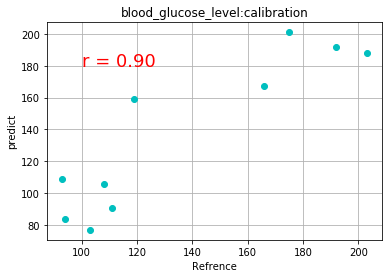

In [124]:
# 散布図を描画（r=に相関係数,保存する場所,色その他は適当に決める）
plt.plot(arr_ref, arr_pred, 'co')
plt.grid()
plt.xlabel('Refrence')
plt.ylabel('predict')
plt.title('blood_glucose_level:calibration')
plt.text(100, 180, 'r = 0.90', fontsize=18, color='r')
plt.savefig('val_result_plot')
plt.show()

# Batch Normalization の実装

In [125]:
# batch normalization 
# 4層NN(入力→中間，中間→出力)
class MLP_13(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP_13, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out
            self.bn1 = L.BatchNormalization(n_units)
            self.bn2 = L.BatchNormalization(n_units)
            

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = self.bn1(h1)
        h3 = F.relu(self.l2(h1))
        h4 = self.bn2(h3)
        return self.l3(h4)
    

def parse_device(args):
    gpu = None
    if args.gpu is not None:
        gpu = args.gpu
    elif re.match(r'(-|\+|)[0-9]+$', args.device):
        gpu = int(args.device)

    if gpu is not None:
        if gpu < 0:
            return chainer.get_device(numpy)
        else:
            import cupy
            return chainer.get_device((cupy, gpu))

    return chainer.get_device(args.device)

In [126]:
# model 決定　1000ノード　1出力
net = MLP_13(1000, 1)
model = L.Classifier(net,
                     lossfun=F.mean_squared_error,
                     accfun=F.r2_score)
model.compute_accuracy = False

model.to_gpu()

In [127]:
# 最適化方法
#optimizer = chainer.optimizers.SGD()
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [128]:
# 学習回数（epoch）とかを決める
updater = training.updaters.StandardUpdater(train_iter, optimizer, device=0)
trainer = training.Trainer(updater, (2000, 'epoch'), out="Result2019_oono/%s" % time.strftime("%Y%m%d%H%M%S"))
out_directory = "./Result2019_oono/%s" % time.strftime("%Y%m%d_%H%M%S")

In [129]:
# オプションです

# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model, device=0))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot for each specified epoch
# frequency = args.epoch if args.frequency == -1 else max(1, args.frequency)
# trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# Print a progress bar to stdout
trainer.extend(extensions.ProgressBar())

# if args.resume:
#     # Resume from a snapshot
#     chainer.serializers.load_npz(args.resume, trainer)


In [130]:
# 訓練実行！
trainer.run()

# モデル保存
net.to_cpu()

chainer.serializers.save_hdf5("/home/fiber_classifier/Desktop/model.hdf" ,obj=net)

numpy.save(arr=id_test, file="/home/fiber_classifier/Desktop/test_id.npy"  )
numpy.save(arr=id_train, file="/home/fiber_classifier/Desktop/train_id.npy" )


epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           22413.1     22689.7                                                        0.0220203     
2           21441       22057.6                                                        0.139448      
3           21330.6     21525                                                          0.259637      
4           21305       21335.2                                                        0.384737      
5           21177       22790.7                                                        0.505605      
6           21137.1     23687.2                                                        0.63814       
7           21044.7     23163.2                                                        0.752932      
8           20929.6     23181.1                                                        0.870029      
9           20879.2     22902.2                                                     

74          4088.8      20144.2                                                        9.00701       
75          4114.26     10986.1                                                        9.13549       
76          3776.88     1196.9                                                         9.26376       
77          3550.13     1500.79                                                        9.39532       
78          3418.1      20553.5                                                        9.5262        
79          3025.32     14166.6                                                        9.65771       
80          2870.02     1860.95                                                        9.78963       
81          2619.99     4189.43                                                        9.9211        
82          2552.69     17547.4                                                        10.0522       
83          2409.58     65331.2                                                   

148         129.105     820.031                                                        18.5419       
149         198.998     2708.52                                                        18.6753       
150         282.025     1965.8                                                         18.8073       
151         508.622     6573.86                                                        18.9402       
152         237.578     8274.33                                                        19.0733       
153         311.059     1094.72                                                        19.2063       
154         193.532     3638.17                                                        19.3427       
155         242.188     1051.53                                                        19.4772       
156         154.856     9966.87                                                        19.6118       
157         321.264     3024.13                                                   

222         158.48      10454.3                                                        28.4753       
223         157.957     764.222                                                        28.6028       
224         147.215     2795.36                                                        28.7312       
225         219.915     794.802                                                        28.8594       
226         252.349     10672.3                                                        28.986        
227         210.236     9414.78                                                        29.113        
228         132.764     1313.21                                                        29.2409       
229         242.576     4896.97                                                        29.3681       
230         354.023     8914.77                                                        29.4959       
231         172.252     2497.56                                                   

296         604.81      741.934                                                        44.7648       
297         230.881     933.367                                                        44.9004       
298         407.997     671.439                                                        45.0348       
299         254.717     712.631                                                        45.1699       
300         314.252     922.698                                                        45.304        
     total [#######...........................................] 15.02%
this epoch [################..................................] 33.33%
       900 iter, 300 epoch / 2000 epochs
    19.314 iters/sec. Estimated time to finish: 0:04:23.999502.
301         222.183     1201.05                                                        45.4395       
302         129.826     780.918                                                        45.5741       
303         136.92      868.113        

368         334.271     6585.5                                                         55.6487       
369         240.55      7167.34                                                        55.7874       
370         189.43      1455.66                                                        55.927        
371         102.353     1504.11                                                        56.0655       
372         77.4049     1020.58                                                        56.206        
373         175.826     2356.5                                                         56.346        
374         469.747     756.034                                                        56.4851       
375         155.715     11951                                                          56.6235       
376         180.292     16498.9                                                        56.7621       
377         205.78      1725.4                                                    

442         346.651     694.74                                                         65.763        
443         366.998     3080.44                                                        65.8953       
444         128.036     838.016                                                        66.0271       
445         265.219     1728.57                                                        66.1577       
446         93.4458     4112.64                                                        66.2894       
447         140.172     835.793                                                        66.4212       
448         94.3093     2877.3                                                         66.5544       
449         270.278     800.423                                                        66.6879       
450         107.376     1995.48                                                        66.8217       
451         104.925     995.784                                                   

516         247.768     903.331                                                        76.4374       
517         135.386     1274.75                                                        76.5753       
518         110.777     1677.07                                                        76.7119       
519         81.425      3832.88                                                        76.8482       
520         79.465      13176.1                                                        76.9857       
521         314.582     5375.37                                                        77.1213       
522         227.556     1122.51                                                        77.2582       
523         128.48      1875.11                                                        77.3931       
524         373.005     2749.16                                                        77.5295       
525         136.479     1640.89                                                   

590         105.598     1722.79                                                        87.4424       
591         481.516     2982.59                                                        87.5834       
592         345.869     739.128                                                        87.7234       
593         128.371     678.308                                                        87.8636       
594         90.701      2981.99                                                        88.0021       
595         162.5       788.703                                                        88.1411       
596         125.925     4794.66                                                        88.2812       
597         110.743     8284.94                                                        88.4221       
598         139.381     5577.72                                                        88.5608       
599         79.4486     1419.8                                                    

664         78.6635     4818.3                                                         97.7766       
665         171.707     1811.95                                                        97.9152       
666         116.849     1269.35                                                        98.0538       
667         412.779     918.616                                                        98.194        
     total [################..................................] 33.35%
this epoch [..................................................]  0.00%
      2000 iter, 667 epoch / 2000 epochs
    20.146 iters/sec. Estimated time to finish: 0:03:18.498483.
668         117.38      1325.53                                                        98.3349       
669         103.798     722.484                                                        98.475        
670         154.455     1586.71                                                        98.6156       
671         256.71      1080.93        

735         275.786     700.637                                                        108.954       
736         218.589     2457.95                                                        109.097       
737         175.261     2191.24                                                        109.241       
738         223.535     1070.41                                                        109.385       
739         152.064     946.661                                                        109.531       
740         288.651     902.656                                                        109.677       
741         100.367     850.181                                                        109.82        
742         104.623     813.857                                                        109.965       
743         508.518     930.32                                                         110.109       
744         238.542     764.87                                                    

809         134.229     756.527                                                        119.697       
810         231.686     1437.56                                                        119.843       
811         95.8783     5729.68                                                        119.988       
812         189.49      1205.73                                                        120.133       
813         154.583     1616.67                                                        120.278       
814         183.875     69213.1                                                        120.423       
815         209.127     5909.78                                                        120.568       
816         358.046     16935                                                          120.714       
817         373.454     866.584                                                        120.859       
818         162.043     9691.8                                                    

883         97.3772     6790.12                                                        131.242       
884         79.1953     1736.83                                                        131.381       
885         217.597     1138.61                                                        131.519       
886         158.65      2163.63                                                        131.658       
887         222.607     745.036                                                        131.796       
888         112.632     1422.78                                                        131.933       
889         199.598     1416.37                                                        132.074       
890         97.831      6729.9                                                         132.213       
891         82.4859     12252                                                          132.352       
892         85.5651     909.691                                                   

957         150.998     867.356                                                        141.595       
958         172.986     811.488                                                        141.738       
959         220.677     895.571                                                        141.88        
960         364.675     877.671                                                        142.023       
961         190.018     1141.68                                                        142.166       
962         248.878     1181.33                                                        142.31        
963         106.307     1257.25                                                        142.451       
964         130.909     2004.23                                                        142.593       
965         156.226     1771.36                                                        142.736       
966         202.893     958.521                                                   

1031        264.886     4736.98                                                        152.133       
1032        134.959     950.1                                                          152.276       
1033        219.531     1573.93                                                        152.419       
     total [#########################.........................] 51.68%
this epoch [#################################.................] 66.67%
      3100 iter, 1033 epoch / 2000 epochs
    20.195 iters/sec. Estimated time to finish: 0:02:23.547318.
1034        272.4       791.714                                                        152.565       
1035        159.796     2893.11                                                        152.708       
1036        580.67      887.775                                                        152.85        
1037        283.236     1713.81                                                        152.994       
1038        234.31      1345.67       

1102        183.986     1984.31                                                        163.895       
1103        89.6582     1640.71                                                        164.039       
1104        172.262     3788.29                                                        164.182       
1105        139.645     3971.45                                                        164.326       
1106        249.75      2014.7                                                         164.47        
1107        264.086     10061                                                          164.613       
1108        210.555     3347.23                                                        164.759       
1109        157.243     763.495                                                        164.905       
1110        79.0696     1910.25                                                        165.049       
1111        82.8524     839.437                                                   

1176        532.496     1305.39                                                        175.036       
1177        144.478     2884.52                                                        175.188       
1178        212.812     3297.8                                                         175.341       
1179        350.123     4238.31                                                        175.492       
1180        482.65      1972.47                                                        175.643       
1181        154.375     2029.55                                                        175.796       
1182        90.9398     2173.42                                                        175.947       
1183        119.136     6368.43                                                        176.098       
1184        451.846     18019.8                                                        176.25        
1185        141.447     3897.7                                                    

1250        174.079     1181.71                                                        186.369       
1251        187.78      3226.45                                                        186.521       
1252        122.484     1238.05                                                        186.673       
1253        96.7573     1672.31                                                        186.825       
1254        217.084     7661.1                                                         186.977       
1255        89.2504     4626.1                                                         187.129       
1256        170.226     5563.59                                                        187.281       
1257        124.516     24890.8                                                        187.433       
1258        102.214     14914.2                                                        187.584       
1259        101.496     1289.47                                                   

1324        580.133     4506.94                                                        199.145       
1325        117.713     6132.27                                                        199.292       
1326        175.76      3546.5                                                         199.438       
1327        327.63      921.473                                                        199.584       
1328        123.399     21805.8                                                        199.727       
1329        178.321     22942.7                                                        199.873       
1330        197.26      822.624                                                        200.018       
1331        122.91      14031.1                                                        200.165       
1332        135.26      860.944                                                        200.31        
1333        161.836     9800.1                                                    

1398        155.443     2329.59                                                        210.112       
1399        104.801     1244.2                                                         210.258       
1400        87.2407     1858.5                                                         210.404       
     total [###################################...............] 70.02%
this epoch [################..................................] 33.33%
      4200 iter, 1400 epoch / 2000 epochs
    19.852 iters/sec. Estimated time to finish: 0:01:30.622039.
1401        282.752     5643.52                                                        210.551       
1402        608.049     13484                                                          210.698       
1403        138.195     2662.99                                                        210.845       
1404        312.295     10994.3                                                        210.993       
1405        218.274     6358.41       

1469        108.739     832.355                                                        220.644       
1470        105.516     10101                                                          220.793       
1471        183.761     17423.8                                                        220.942       
1472        180.837     4743.43                                                        221.091       
1473        140.874     3850.48                                                        221.24        
1474        222.866     6354.53                                                        221.388       
1475        89.7872     1585.54                                                        221.537       
1476        181.079     1231.02                                                        221.687       
1477        485.831     1122.84                                                        221.837       
1478        327.376     774.744                                                   

1543        193.976     2972.74                                                        231.831       
1544        114.115     1346.74                                                        231.984       
1545        101.902     3931.32                                                        232.137       
1546        100.925     1357.86                                                        232.289       
1547        188.367     1730.21                                                        232.441       
1548        158.876     7018.46                                                        232.593       
1549        86.7252     4097.48                                                        232.747       
1550        64.8461     2501.26                                                        232.931       
1551        192.75      2340.94                                                        233.113       
1552        162.624     1259.99                                                   

1617        284.971     1265.05                                                        245.612       
1618        116.851     999.659                                                        245.768       
1619        157.812     1075.91                                                        245.921       
1620        141.052     2059.54                                                        246.075       
1621        105.789     1044.87                                                        246.228       
1622        91.6541     1143.25                                                        246.38        
1623        307.609     3085.74                                                        246.532       
1624        311.878     1062.4                                                         246.685       
1625        185.942     2596.14                                                        246.837       
1626        115.831     3138.96                                                   

1691        130.611     14192                                                          256.804       
1692        93.3628     907.642                                                        256.957       
1693        65.7659     4475.56                                                        257.111       
1694        98.5847     2065.69                                                        257.266       
1695        64.5578     965.426                                                        257.42        
1696        142.073     2192.51                                                        257.574       
1697        484.892     7400.71                                                        257.727       
1698        184.698     5698.69                                                        257.881       
1699        136.54      1280.88                                                        258.035       
1700        146.422     3009.97                                                   

1765        211.325     1758.24                                                        268.139       
1766        257.104     1918.11                                                        268.291       
1767        173.086     2239.91                                                        268.444       
     total [############################################......] 88.35%
this epoch [..................................................]  0.00%
      5300 iter, 1767 epoch / 2000 epochs
    19.654 iters/sec. Estimated time to finish: 0:00:35.564720.
1768        185.69      1212.91                                                        268.598       
1769        488.344     919.189                                                        268.751       
1770        101.688     2328.75                                                        268.903       
1771        122.503     1844.12                                                        269.082       
1772        454.066     5141.44       

1836        106.505     2634.33                                                        279.166       
1837        107.897     1515.13                                                        279.321       
1838        126.883     923.096                                                        279.476       
1839        237.789     1053.05                                                        279.631       
1840        246.033     1308.47                                                        279.786       
1841        165.494     1102.99                                                        279.941       
1842        186.128     1403.04                                                        280.095       
1843        81.3828     945.231                                                        280.249       
1844        200.885     9076.08                                                        280.404       
1845        416.554     9805.75                                                   

1910        259.462     4633.06                                                        290.88        
1911        135.25      4727.4                                                         291.058       
1912        106.873     996.795                                                        291.22        
1913        129.666     1692.6                                                         291.383       
1914        173.723     1192.19                                                        291.546       
1915        382.586     9610.83                                                        291.708       
1916        364.288     13141.8                                                        291.87        
1917        353.446     1891.23                                                        292.032       
1918        330.911     27362.2                                                        292.194       
1919        204.552     5074.15                                                   

1984        230.817     1428.46                                                        303.018       
1985        49.5731     979.972                                                        303.182       
1986        84.3043     4784.97                                                        303.347       
1987        126.538     6239.64                                                        306.385       
1988        210.565     911.874                                                        306.549       
1989        386.184     5772.26                                                        306.714       
1990        204.721     4376.23                                                        306.879       
1991        128.417     3801.88                                                        307.043       
1992        533.599     3974.72                                                        307.208       
1993        134.516     1610.96                                                   

In [103]:
# 検証（テストデータ）
test_iter.reset()

test_batch = test_iter.next()
test_spc, test_ref = concat_examples(test_batch)  # Test Dataset
for i in range(10):
    ref = test_ref[i]
    pred = net(test_spc[i].reshape(1, -1)).data
    print("Ref: %d, Pred: %d " % (ref, pred))


Ref: 97, Pred: 141 
Ref: 150, Pred: 141 
Ref: 172, Pred: 141 
Ref: 167, Pred: 141 
Ref: 142, Pred: 141 
Ref: 160, Pred: 141 
Ref: 160, Pred: 141 
Ref: 133, Pred: 141 
Ref: 149, Pred: 141 
Ref: 129, Pred: 141 


/usr/local/lib/python3.4/dist-packages/chainer/functions/normalization/batch_normalization.py:114: UserWarning: A batch with no more than one sample has been given to F.batch_normalization. F.batch_normalization will always output a zero tensor for such batches. This could be caused by incorrect configuration in your code (such as running evaluation while chainer.config.train=True), but could also happen in the last batch of training if non-repeating iterator is used.
  UserWarning)


In [104]:
# 検証（訓練データ）
train_iter.reset()

train_batch = train_iter.next()
train_spc, train_ref = concat_examples(train_batch)  # Test Dataset
for i in range(10):
    cal_ref = train_ref[i]
    cal_pred = net(train_spc[i].reshape(1, -1)).data
    print("Ref: %d, Pred: %d " % (cal_ref, cal_pred))

Ref: 93, Pred: 141 
Ref: 103, Pred: 141 
Ref: 109, Pred: 141 
Ref: 146, Pred: 141 
Ref: 109, Pred: 141 
Ref: 194, Pred: 141 
Ref: 203, Pred: 141 
Ref: 175, Pred: 141 
Ref: 166, Pred: 141 
Ref: 121, Pred: 141 


/usr/local/lib/python3.4/dist-packages/chainer/functions/normalization/batch_normalization.py:114: UserWarning: A batch with no more than one sample has been given to F.batch_normalization. F.batch_normalization will always output a zero tensor for such batches. This could be caused by incorrect configuration in your code (such as running evaluation while chainer.config.train=True), but could also happen in the last batch of training if non-repeating iterator is used.
  UserWarning)


In [ ]:
# arr_ref:参照値，arr_pred:予測値（テストデータ）
arr_ref = numpy.array([97, 150, 172, 167, 142, 160, 160, 133, 149, 129])
arr_pred = numpy.array([59, 159, 172, 147, 125, 144, 180, 115, 175, 158])
print("Ref:", arr_ref.shape)
print("Pred:",arr_pred.shape)

In [ ]:
# 相関係数の算出＆表示
cor = numpy.corrcoef(arr_ref, arr_pred)[0, 1]
print(cor)

In [ ]:
# 散布図を描画（r=に相関係数,保存する場所,色その他は適当に決める）
plt.plot(arr_ref, arr_pred, 'co')
plt.grid()
plt.xlabel('Refrence')
plt.ylabel('predict')
plt.title('blood_glucose_level:calibration')
plt.text(100, 180, 'r = 0.94', fontsize=18, color='r')
plt.savefig('val_result_plot')
plt.show()